## Import modules

In [1]:
# sklearn
from sklearn.datasets import fetch_openml

import numpy as np

import matplotlib.pyplot as plt

## Loading data

In [2]:
%%time
full_data = fetch_openml("mnist_784")

CPU times: user 16.8 s, sys: 216 ms, total: 17 s
Wall time: 17 s


In [3]:
full_data.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
full_data['target'].shape

(70000,)

In [5]:
train_size = 60000
test_size = 10000

## Separate full_data to train and test

In [6]:
train_data = {'data': full_data['data'][:train_size], 'target': full_data['target'][:train_size]}
test_data = {'data': full_data['data'][train_size:], 'target': full_data['target'][train_size:]}

## Let's visualize first 10 digits from train:

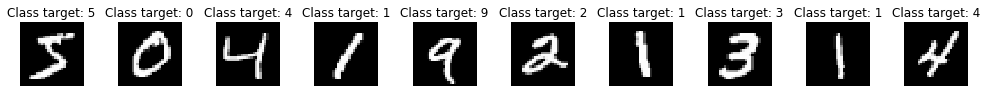

In [7]:
digits_to_show = 10
fig = plt.figure(figsize=(15, 15))
for i in range(digits_to_show):
    ax = fig.add_subplot(1, digits_to_show + 1, i+1)
    ax.imshow(train_data['data'][i].reshape(28, 28), cmap=plt.get_cmap('Greys_r'))
    ax.set_title('Class target: ' + train_data['target'][i])
    ax.axis("off")
plt.tight_layout()
plt.show()

## Testing my KNNClassifier

In [8]:
train_data['target'] = train_data['target'].astype(int)
test_data['target'] = test_data['target'].astype(int)

In [100]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from distances import euclidean_distance, cosine_distance


class KNNClassifier:
    def __init__(self,
                 k=10,
                 strategy='my_own',
                 metric='euclidean',
                 weights=False,
                 test_block_size=100
                 ):
        """
        params:
            * k - amount of nearest neighbours(nn)
            * strategy - nn searching algorithm. Possible values:
                - 'my_own' - self-realization
                - 'brute' - from sklearn.neighbors.NearestNeighbors(algorithm='brute')
                - 'kd_tree' - from sklearn.neighbors.NearestNeighbors(algorithm='kd_tree')
                - 'ball_tree' - from sklearn.neighbors.NearestNeighbors(algorithm='ball_tree')
            * metric:
                - 'euclidean' - euclidean metric
                - 'cosine' - cosine metric
            * weights - bool variable.
                - True - weighted KNN(with distance)
                - False - simple KNN
            * test_block_size - size of test block
        """

        self.k = k
        self.strategy = strategy
        self.metric = metric
        if weights:
            self.weights = 'distance'
        else:
            self.weights = 'uniform'
        self.test_block_size = test_block_size

    def fit(self, X, y):
        """
        params:
            * X - train data
            * y - targets for train data
        """

        self.model = None
        if self.strategy != 'my_own':
            self.model = NearestNeighbors(n_neighbors=self.k, algorithm=self.strategy)
            self.X_train = X
            self.y_train = y
            self.model.fit(X, y)
        else:
            self.X_train = X
            self.y_train = y

    def find_kneighbors(self, X, return_distance):
        """
        params:
            * X - objects sample
            * return_distance - bool variable

        return values:
            * If return_distance == True:
                * tuple with two numpy array with size (X.shape[0], k), where:
                  [i, j] elem of first array must be the distance between
                  i-th object and his j-th nearest neighbour
                  [i, j] elem of second array must be the index of j-th nearest neighbour to i-th object
            * If return_distance == False:
                * only second array
        """

        if self.strategy != 'my_own':
            self.distances, \
                self.neigh_idxs = self.model.kneighbors(X, n_neighbors=self.k)
        else:
            if self.metric == 'euclidean':
                self.distances = euclidean_distance(X, self.X_train)
                self.neigh_idxs = np.argsort(self.distances,
                                             axis=1,
                                             kind='quicksort')[:, :self.k]
                if return_distance:
                    self.distances = np.sort(self.distances,
                                             axis=1,
                                             kind='quicksort')[:, :self.k]

            elif self.metric == 'cosine':
                self.distances = cosine_distance(X, self.X_train),
                self.neigh_idxs = np.argsort(self.distances,
                                             axis=1,
                                             kind='quicksort')[:, :self.k]
                if return_distance:
                    self.distances = np.sort(self.distances,
                                             axis=1,
                                             kind='quicksort')[:, :self.k]

        if return_distance:
            return self.distances, self.neigh_idxs
        return self.neigh_idxs

    def predict(self, X):
        """
        params:
            * X - test objects

        return values:
            * numpy array with size X.shape[0] of predictions for test objects from X
        """

        preds = np.zeros((X.shape[0]))
        split_size = X.shape[0] // self.test_block_size + \
                     int(X.shape[0] % self.test_block_size != 0)
        for i, split in enumerate(np.array_split(X, split_size)):
            if i != 0:
                del self.distances
                del self.neigh_idxs
            self.find_kneighbors(split, True)
            
            print(self.distances.shape)
            
            print(1 / self.distances * self.y_train[self.neigh_idxs])
            print((self.distances * self.y_train[self.neigh_idxs]).shape)
            for i in range(len(np.unique(self.y_train))):
                
            # for j, idx in enumerate(self.neigh_idxs):
            #     if self.weights == 'distance':
            #         counts = np.bincount(self.y_train[idx],
            #                              weights=1 / self.distances[j, :self.k])
            #     elif self.weights == 'uniform':
            #         counts = np.bincount(self.y_train[idx])
            #     preds[j + i * self.test_block_size] = np.argmax(counts)
        return preds


n_test_samples = 500

In [101]:
KNN_model = KNNClassifier(5, strategy='my_own', weights=True)

In [102]:
%%time
KNN_model.fit(X=train_data['data'], y=train_data['target'])

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 9.06 µs


In [103]:
%%time
# KNN_model.find_kneighbors(test_data['data'][:n_test_samples], False)
#14.4 - True # 500 samples
#9.56 - False # 500 samples

#2min 48s - True # 10k samples
#2min 11s - False # 10k samples

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


In [104]:
# array([[53843, 38620, 16186, 27059, 47003],
#        [28882, 49160, 24612, 31634, 16902],
#        [58741, 46512, 15224, 47333, 44038],
#        ...,
#        [46124, 13852, 17844, 18510, 33708],
#        [29034, 43258, 56724, 43706, 19908],
#        [49436, 41800, 50670, 11132, 55520]])

In [105]:
%%time
preds = KNN_model.predict(test_data['data'][:n_test_samples])
#12.5 s - True # 500 samples
#9.47 s - False # 500 samples

# 6min 53s - True # 10k samples
# 6min 16s - False # 10k samples

(100, 5)
[[0.01034609 0.00881627 0.00811428 0.00809713 0.00782385]
 [0.00171979 0.00165038 0.0015553  0.00154785 0.00150286]
 [0.00310885 0.00300785 0.00293214 0.0027195  0.0026502 ]
 [0.         0.         0.         0.         0.        ]
 [0.00366121 0.00364948 0.00342072 0.00341333 0.00334958]
 [0.00335431 0.00320388 0.00268067 0.00256467 0.00253474]
 [0.00307052 0.00294766 0.00272151 0.00271986 0.00271757]
 [0.00697837 0.00644698 0.00639429 0.00617068 0.00612176]
 [0.00288127 0.00287499 0.00278209 0.00259055 0.00256066]
 [0.00907626 0.00784855 0.00762948 0.00747711 0.00720418]
 [0.         0.         0.         0.         0.        ]
 [0.00409729 0.00409117 0.00398453 0.00394614 0.00390878]
 [0.01086575 0.01034864 0.00997083 0.00955401 0.00922034]
 [0.         0.         0.         0.         0.        ]
 [0.00160957 0.0015762  0.0015735  0.0015356  0.00153251]
 [0.00352991 0.003404   0.00333511 0.00330306 0.00320156]
 [0.01021522 0.0084887  0.00810472 0.00808624 0.0080777 ]
 [0.0

(100, 5)
[[0.0019738  0.00195479 0.00194453 0.00189922 0.00189869]
 [0.00515942 0.00489738 0.00467267 0.00463385 0.00455869]
 [0.00218751 0.00208156 0.00205904 0.00203487 0.00201112]
 [0.00239946 0.0023785  0.00235296 0.00219151 0.00203989]
 [0.00261267 0.00256411 0.00246029 0.00234215 0.00231807]
 [0.00314178 0.00291397 0.00286893 0.00276583 0.00271526]
 [0.00772122 0.00738257 0.00731562 0.00709565 0.00702543]
 [0.00442418 0.00419477 0.00401183 0.00391088 0.00377082]
 [0.00173487 0.00171135 0.00160048 0.00159334 0.00156494]
 [0.00706502 0.00643597 0.00632132 0.0062735  0.00624222]
 [0.00330773 0.00327663 0.00327497 0.00326037 0.00323315]
 [0.00413666 0.0037032  0.003689   0.00368528 0.00364564]
 [0.00775061 0.00722191 0.00712015 0.00705944 0.00668871]
 [0.00322262 0.00295282 0.0029381  0.0028409  0.00280872]
 [0.01062867 0.00989653 0.00941033 0.00928184 0.00916163]
 [0.         0.         0.         0.         0.        ]
 [0.00246503 0.00244487 0.00238758 0.00236018 0.00235594]
 [0.0

(100, 5)
[[0.00143578 0.00139445 0.00132313 0.00131756 0.00131131]
 [0.00637429 0.00635917 0.00618519 0.00610563 0.00607454]
 [0.00187266 0.00183519 0.0018245  0.00175893 0.00172139]
 [0.00580574 0.00566741 0.00536929 0.00500297 0.00432655]
 [0.00152528 0.00146108 0.00496395 0.00139598 0.00138956]
 [0.00279082 0.00268915 0.002673   0.00264626 0.00261609]
 [0.00337333 0.00326158 0.00324018 0.00318974 0.00311948]
 [0.         0.         0.         0.         0.        ]
 [0.00242355 0.00236405 0.00229322 0.0022311  0.00220532]
 [0.00157091 0.00140312 0.00139247 0.00137527 0.00134072]
 [0.00779911 0.00771687 0.00759651 0.00733969 0.00733108]
 [0.00975911 0.00865247 0.00849996 0.00833164 0.0081808 ]
 [0.00197076 0.00321437 0.00181086 0.00295945 0.00290981]
 [0.00892041 0.00773027 0.00772007 0.00683921 0.00681144]
 [0.01221946 0.00807268 0.00795106 0.00788163 0.00773014]
 [0.00680823 0.00665885 0.00663352 0.00656101 0.00645914]
 [0.00222772 0.00212493 0.00211624 0.0020758  0.00207431]
 [0.0

In [44]:
arr_my = KNN_model.find_kneighbors(test_data['data'][:500], return_distance=False)

In [45]:
sum(preds.astype(int) - test_data['target'][:n_test_samples].astype(int) == 0) / test_data['target'][:n_test_samples].size

0.084

## Testing distances

In [ ]:
from distances import euclidean_distance, cosine_distance

In [ ]:
k = 2
test_arr = np.array([np.arange(i, k + i) for i in range(k)])
# test_arr[-1, -3] = 200

In [ ]:
cosine_distance(test_arr, test_arr)

In [ ]:
from scipy.spatial.distance import pdist

In [ ]:
pdist(test_arr)

In [ ]:
import numpy as np


# def cosine_distance(X, Y):
#     """
#     params:
#         * X - np.array with size N x D
#         * Y - np.array with size M x D
#     return values:
#         * np.array with size N x M, where [i, j] - cosine distance between i-th vector from X and
#                                                                               j-th vector from Y
#     """
    
#     X = X[None, :, :]
#     Y = Y[:, None, :]
#     result = np.sum(X * Y, axis=2)
#     result /= np.sqrt(np.sum(X ** 2, axis=2))
#     result /= np.sqrt(np.sum(Y ** 2, axis=2))
#     return 1 - result

def euclidean_distance(X, Y):
    """
    params:
        * X - np.array with size N x D
        * Y - np.array with size M x D
    return values:
        * np.array with size N x M, where [i, j] - euclidean distance between i-th vector from X and
                                                                              j-th vector from Y
    """

    X_sqr = np.sum(X ** 2, axis=1)[:, None]
    print(X_sqr.shape)
    Y_sqr = np.sum(Y ** 2, axis=1)
    print(Y_sqr.shape)
    return np.sqrt(X_sqr - 2 * np.dot(X, Y.T) + Y_sqr)

In [ ]:
X = np.arange(1, 10000)
np.sum(X[[1, 2, 5, 6]])

In [ ]:
%load_ext memory_profiler

In [ ]:
%%time
%%memit
print(euclidean_distance(np.ones((2000, 1000)) * 5, np.ones((500, 1000))))
#2.22 s - new on 200x500

#763 ms - old on 200x500
#7725.48 


In [ ]:
np.shape(X[None, ...] - Y[:, None, :])

In [ ]:
%%time
std_norm = np.linalg.norm(X, axis=1)
print('done')

In [ ]:
%%time
my_norm = np.sqrt(np.sum(X ** 2, axis=1))
print('done')

In [ ]:
sum(std_norm != my_norm)

## Testing cross_validation

In [ ]:
import numpy as np


def kfold(n, n_folds):
    """
    params:
        * n - objects amount in sample
        * n_folds - folds amount
    return values:
        * list with size n_folds, where every element is tuple of two 1D numpy array:
            * first array contains indices of train samples
            * second array contains indices of validation samples
    """
    
    indices = np.arange(n)
    size_of_one_fold = int(len(indices) / n_folds)
    size_with_folds = size_of_one_fold * n_folds
    out_elemnts_amount = len(indices) - size_with_folds
    train_test_idx_list = []
    for i in range(n_folds):
        test_idx = indices[i * size_of_one_fold:(i + 1) * size_of_one_fold]
        if out_elemnts_amount > 0:
            test_idx = np.append(test_idx, n - out_elemnts_amount)
            out_elemnts_amount -= 1
        train_idx = np.array(list((set(indices) - set(test_idx))))
        train_test_idx_list.append((train_idx, test_idx))
    return train_test_idx_list
    

def knn_cross_val_score(X, y, k_list, score, cv, **kwargs):
    """
    params:
        * X - train sample
        * y - train targets
        * k_list - list of checking values for amount of nearest neighbors
        * score - metric name:
            * accuracy
        * cv - output from kfold or stratified_kfold, if params is None, then need to use kfold in this function
        * **kwargs - constructor parameters of KNNClassifier class
    """
    
    pass